# Criar um pipeline de dados no Azure

O pipeline compara um registro específico com uma base maior e verifica se ele já existe ou não.

Importando 2 fontes de dados, uma de uma tabela WareHouse e outro de um arquivo texto CSV

O coletor junta os dados e passa por uma transformação no qual faz a comparação um registro específico(tabela warehouse) com uma base maior(arquivo texto CSV) e verifica se ele já existe ou não.

Por final exporta em uma tabela externa o valor resultante

Iniciar clonando um repositio:

In [ ]:
 rm -r dp-203 -f
 git clone https://github.com/MicrosoftLearning/dp-203-azure-data-engineer dp-203

Importar todos os arquivos:

In [ ]:
cd dp-203/Allfiles/labs/10
./setup.ps1

## Implementando um pipeline

Iniciando pela criação do fluxo de dados

Nome: LoadProducts

Preparo do serviço vinculado: synapsexxxxxxx-WorkspaceDefaultStorage.

Preparo da pasta de armazenamento: container = files; Diretório = stage_products.

resultado:

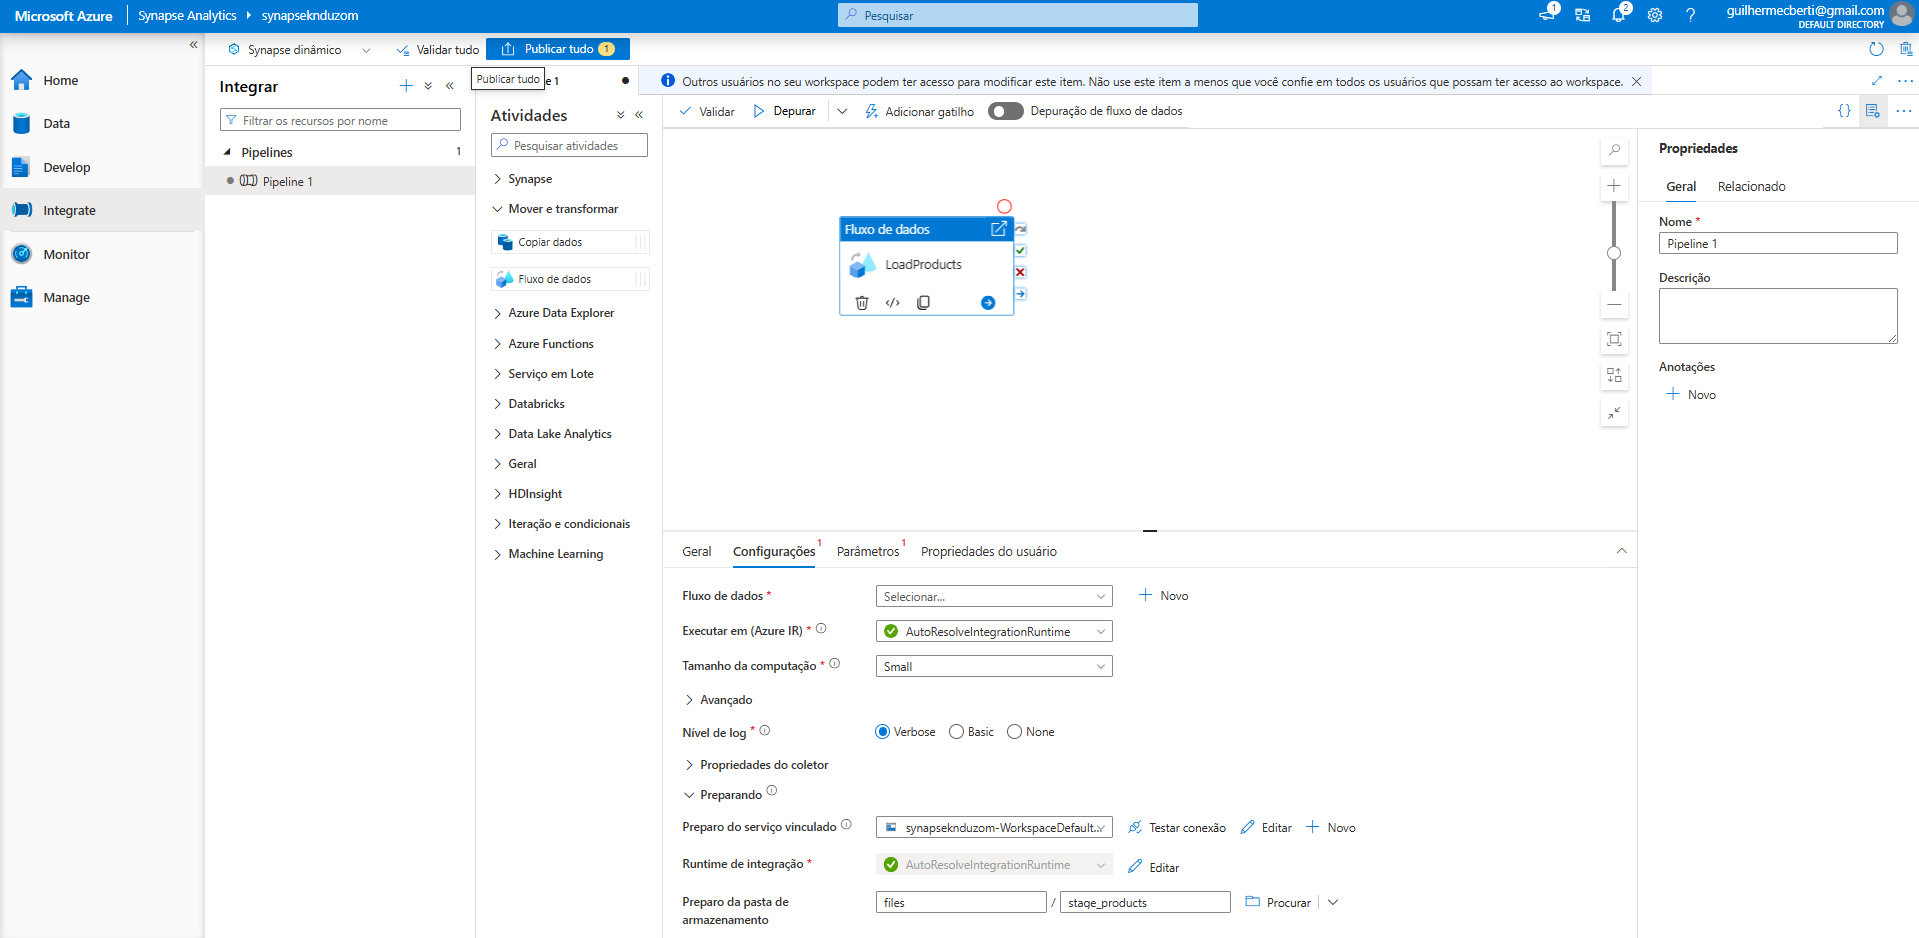

**Configurando o fluxo de dados**

nome: LoadProductsData

**Adicionando e configurando fontes**

Nome do fluxo de saída: ProductsText

Descrição: Products text data

Tipo de fonte: Conjunto de dados de integração

Dataset: Azure Datalake Storage Gen2

Formato: texto delimitado(CSV)

Nome: Products_Csv

Serviço vinculado: synapsexxxxxxx-WorkspaceDefaultStorage

Caminho do arquivo: files/data/Product.csv

Primeira linha como cabeçalho: Selecionado

Importar esquema: da conexão/repositório

**Configuração Projeção**

ProductID: string

ProductName: string

Color: string

Size: string

ListPrice: decimal

Discontinued: boolean

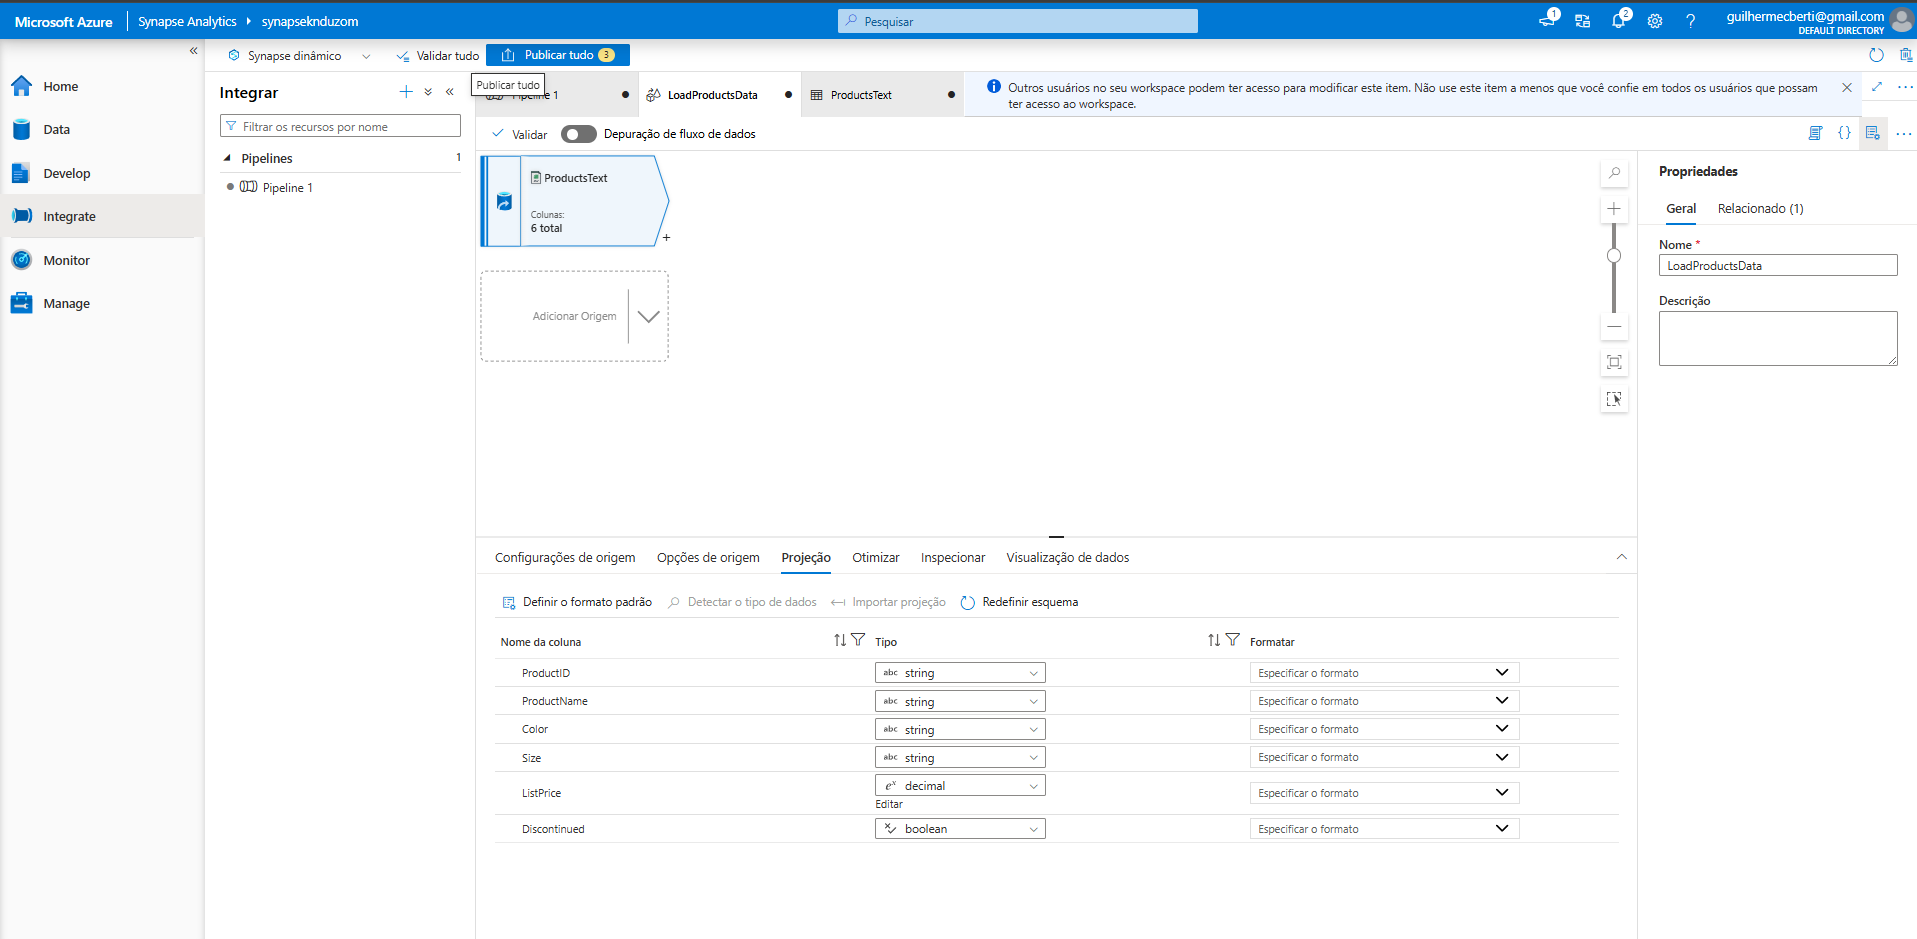

**Configurando segunda fonte**

Nome do fluxo de saída: ProductTable

Descrição: Product table

Tipo de fonte: Conjunto de dados de integração

Dataset: Azure Synapse Analytics

Nome: DimProduct

serviço vinculado: Novo

Nome: Data_Warehouse

Descrição: Dedicated SQL pool

Conectar-se via runtime de integração: AutoResolveIntegrationRuntime

Método de seleção de conta: From Azure subscription

Tipo de Autenticação: System-assigned managed identity

Nome da tabela: dbo.DimProduct

Importar esquema: Da conexão/repositório



**Configuração Projeção**

ProductKey: integer

ProductAltKey: string

ProductName: string

Color: string

Size: string

ListPrice: decimal

Discontinued: boolean

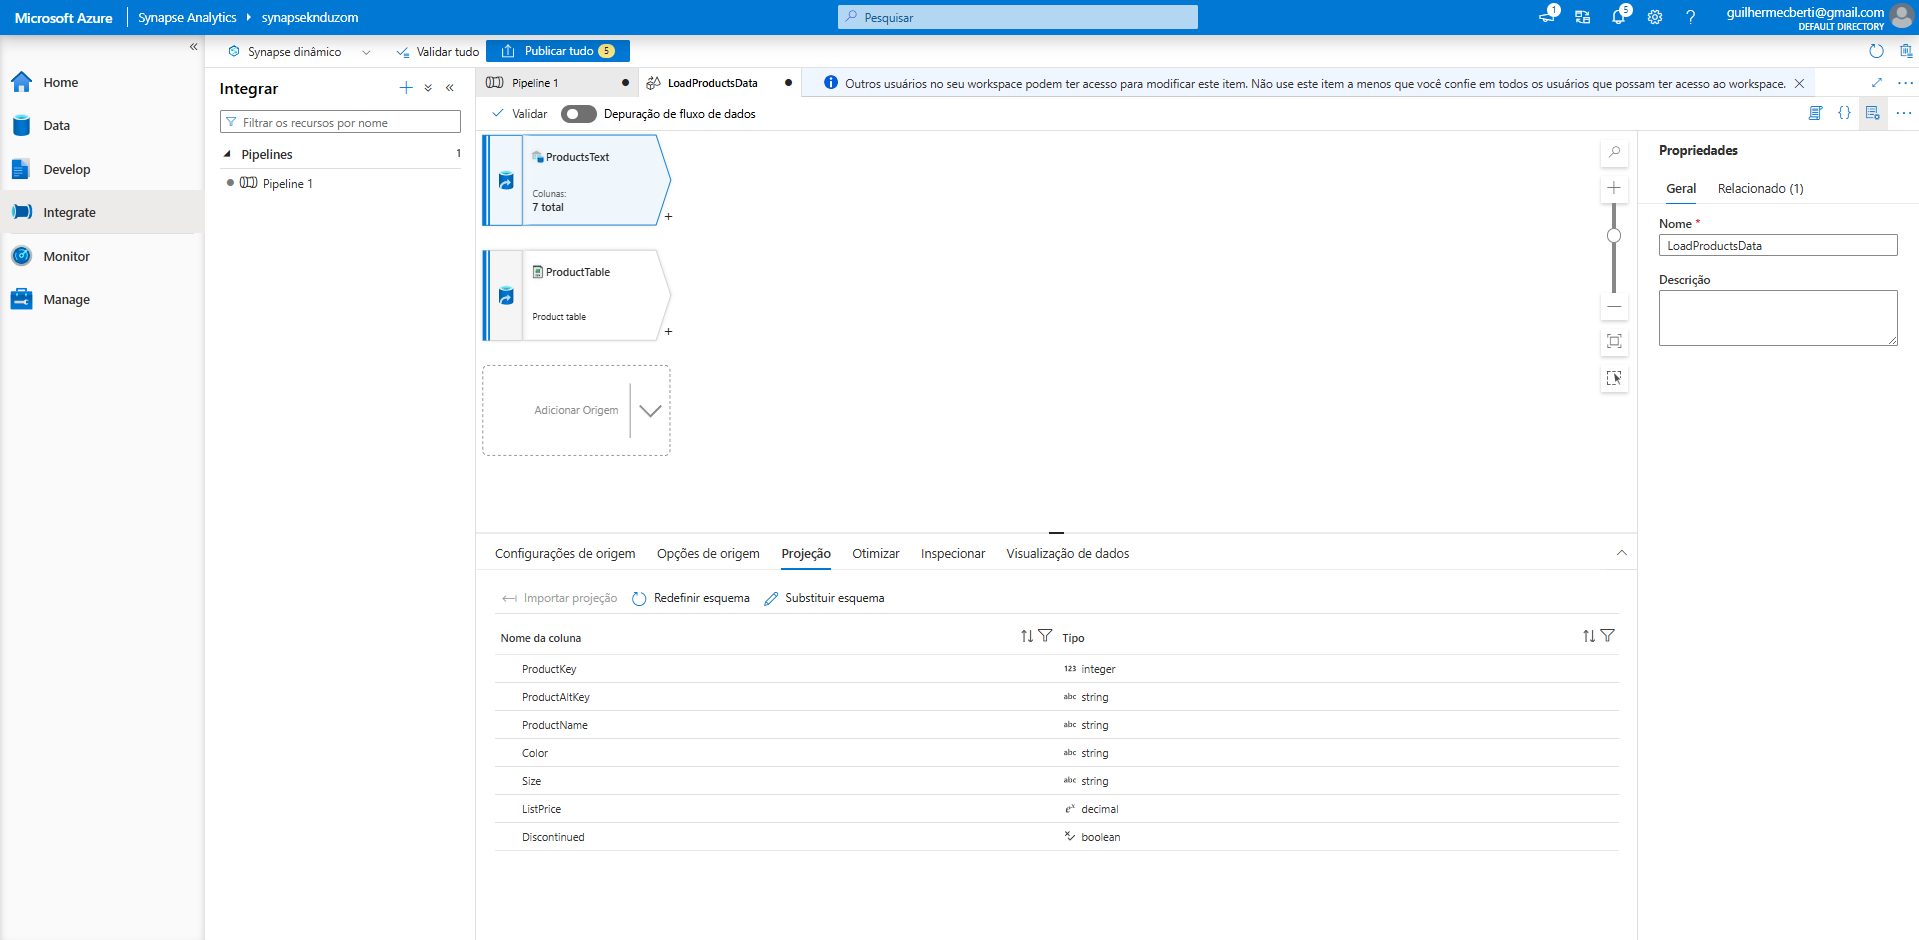

**Adicionando uma pesquisa**

Nome do fluxo de saída: Nome do fluxo de saída

Descrição: Matched product data

Fluxo primário: ProductText

Fluxo de pesquisa: ProductTable

Corresponder em: Última linha

Condições de classificação: ProductID Crescente

Condições de pesquisa: ProductAltKey == ProductID



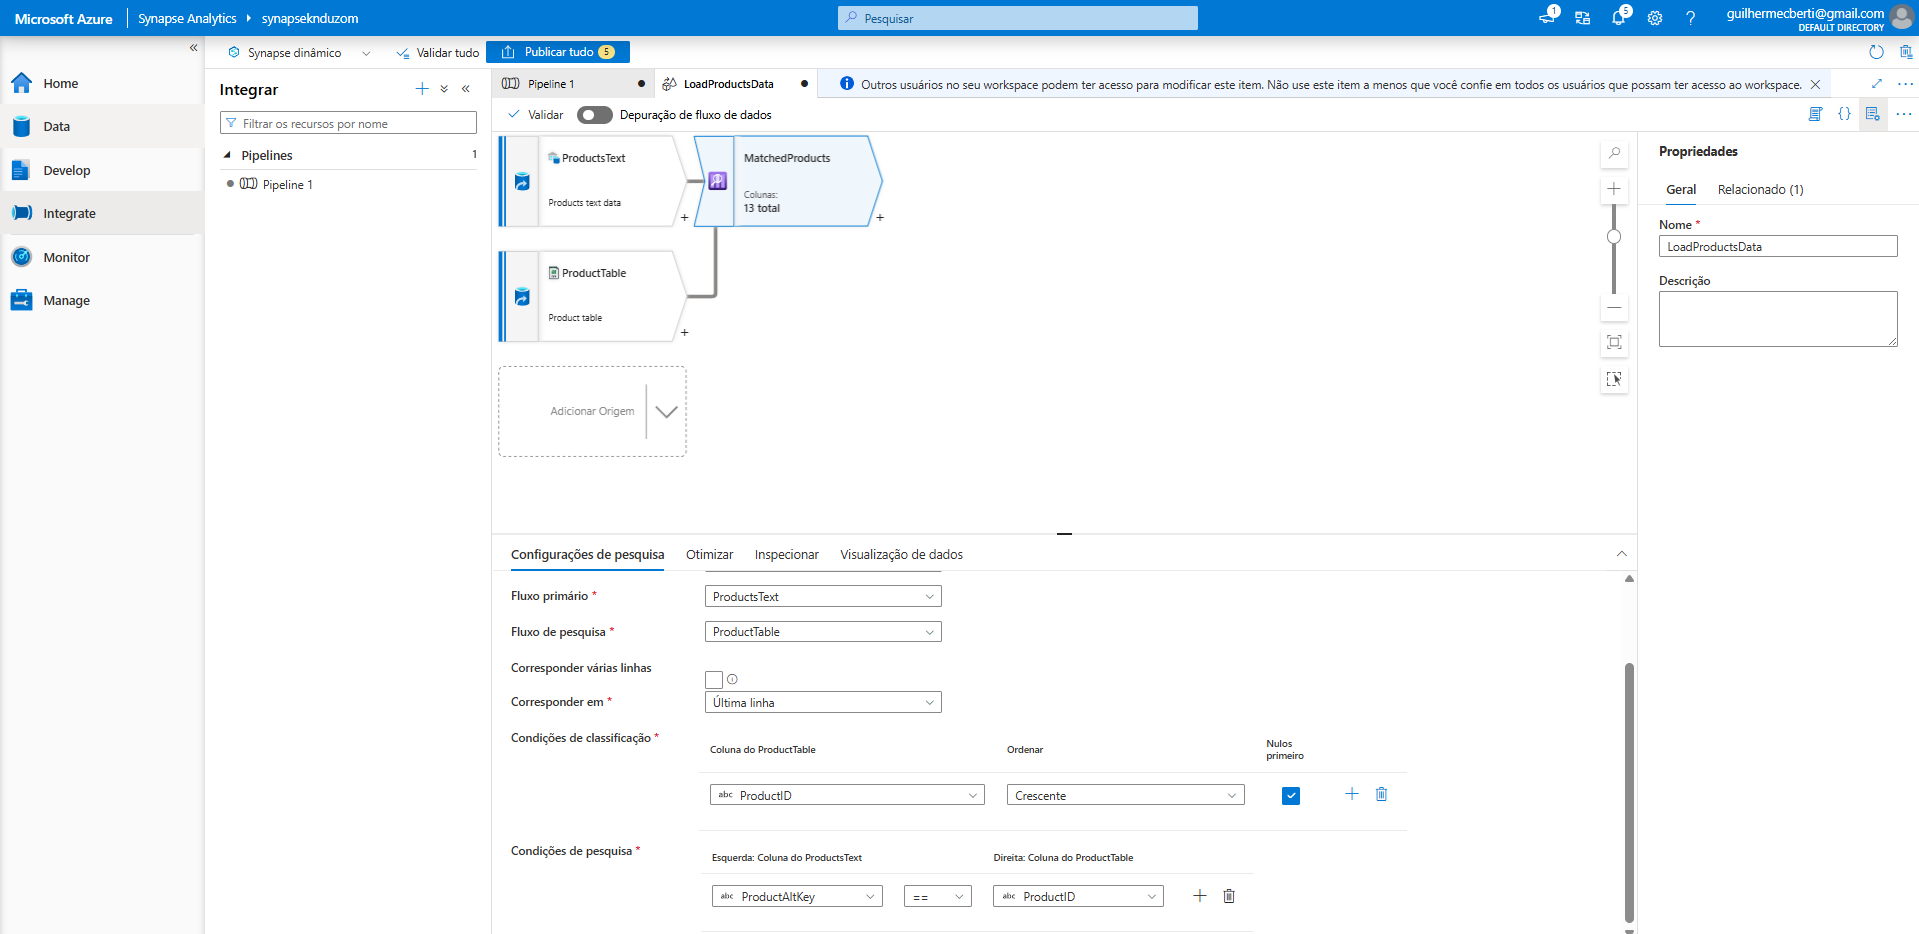

A pesquisa retorna um conjunto de colunas de ambas as fontes

Formando uma junção que corresponde à coluna ProductID no arquivo de texto à coluna ProductAltKey na tabela do data warehouse.

**Adicionando uma linha de alteração**

Nome do fluxo de saída: SetLoadAction

Descrição: Insert new, upsert existing

Fluxo de entrada: MatchedProducts

Condições de alteração da linha: Inserir se = isNull(ProductKey); Executar upsert se = not(isNull(ProductKey));

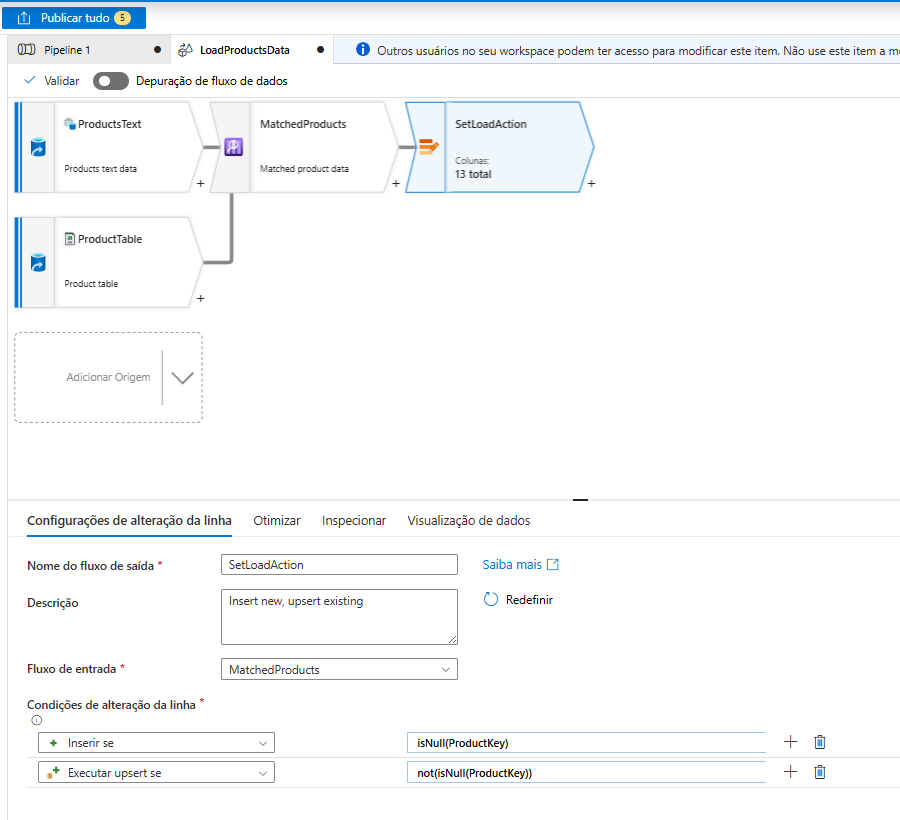

A etapa alterar linha configura o tipo de ação de carga a ser executada para cada linha.

Quando não houver nenhuma linha existente na tabela (o ProductKey = NULL), a linha do arquivo de texto será inserida.

Quando já houver uma linha para o produto, um upsert será executado para atualizar a linha existente.

**Adicionando um Coletor**

Coletor:

Nome do fluxo de saída: DimProductTable

Descrição: Load DimProduct table

Configuração:

Fluxo de entrada: SetLoadAction

Tipo de coletor: Conjunto de dados de integração

Conjunto de Dados: DimProduct

Método de atualização: Permitir a inserção, Permitir o upsert

Colunas de chaves: ProductAltKey

Mapeamento:

ProductID: ProductAltKey

ProductsText@ProductName: ProductName

ProductsText@Color: Color

ProductsText@Size: Size

ProductsText@ListPrice: ListPrice

ProductsText@Discontinued: Discontinued

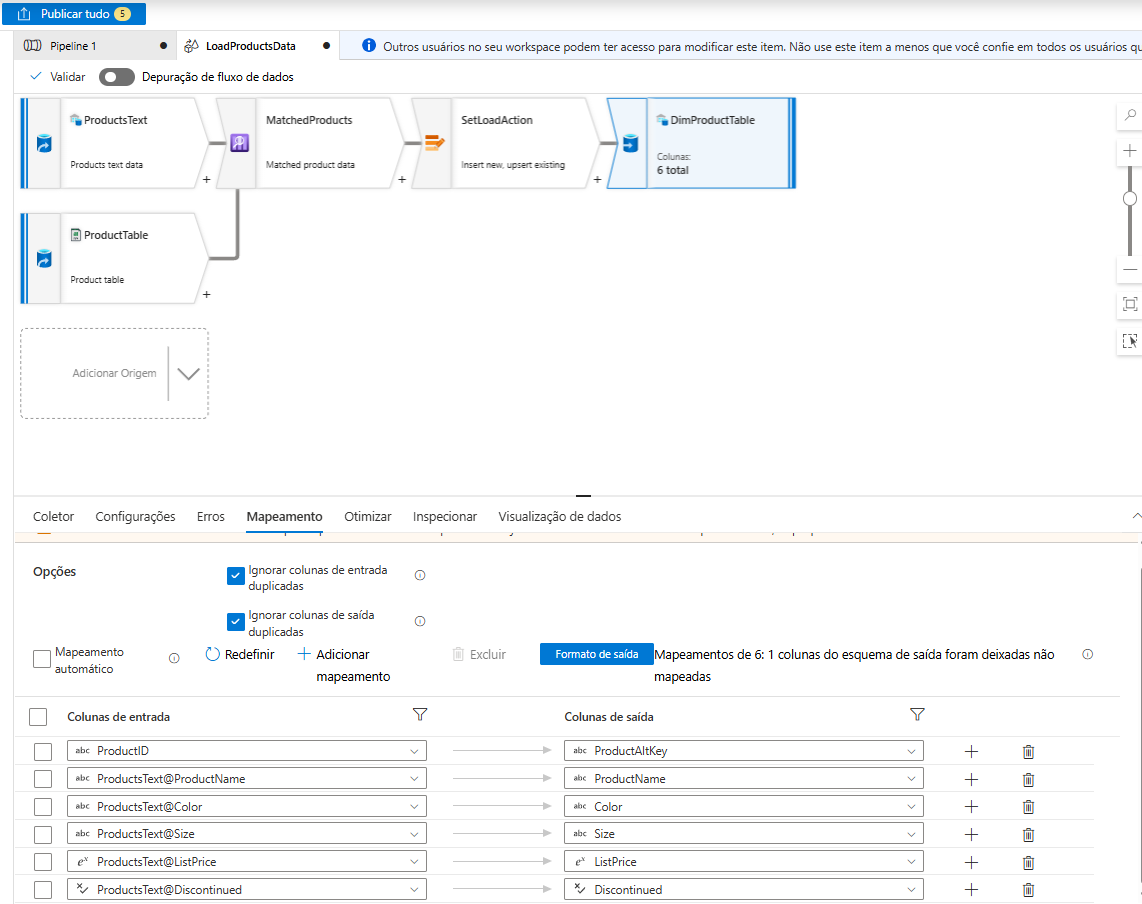

Depurei e o resultado foi que eles indica uma linha inserida (para o produto AR5381 existente)

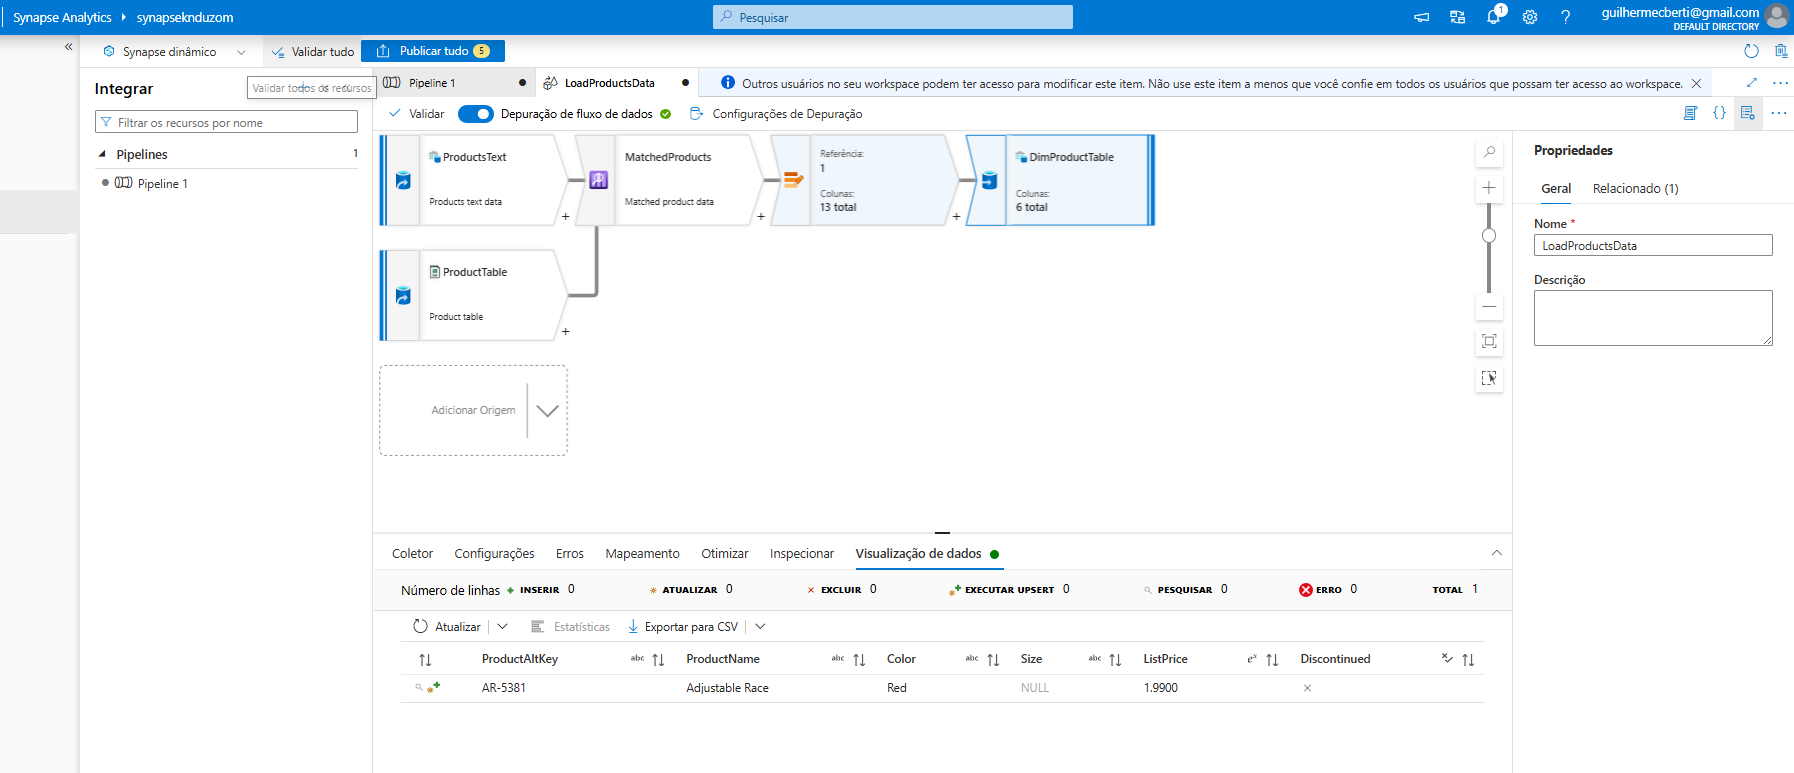

**executando o pipeline**

Adicionei um gatilho e indiquei para Acionar agora.

Após alguns minutos, execução foi bem-sucedida do pipeline.

Então em Data abri um script SQL com as as 100 primeiras linhas da tabela dbo.DimProduct.

resultado final, com a tabela com dados carregados pelo pipeline(uma linha com o produto AR5381 existente):

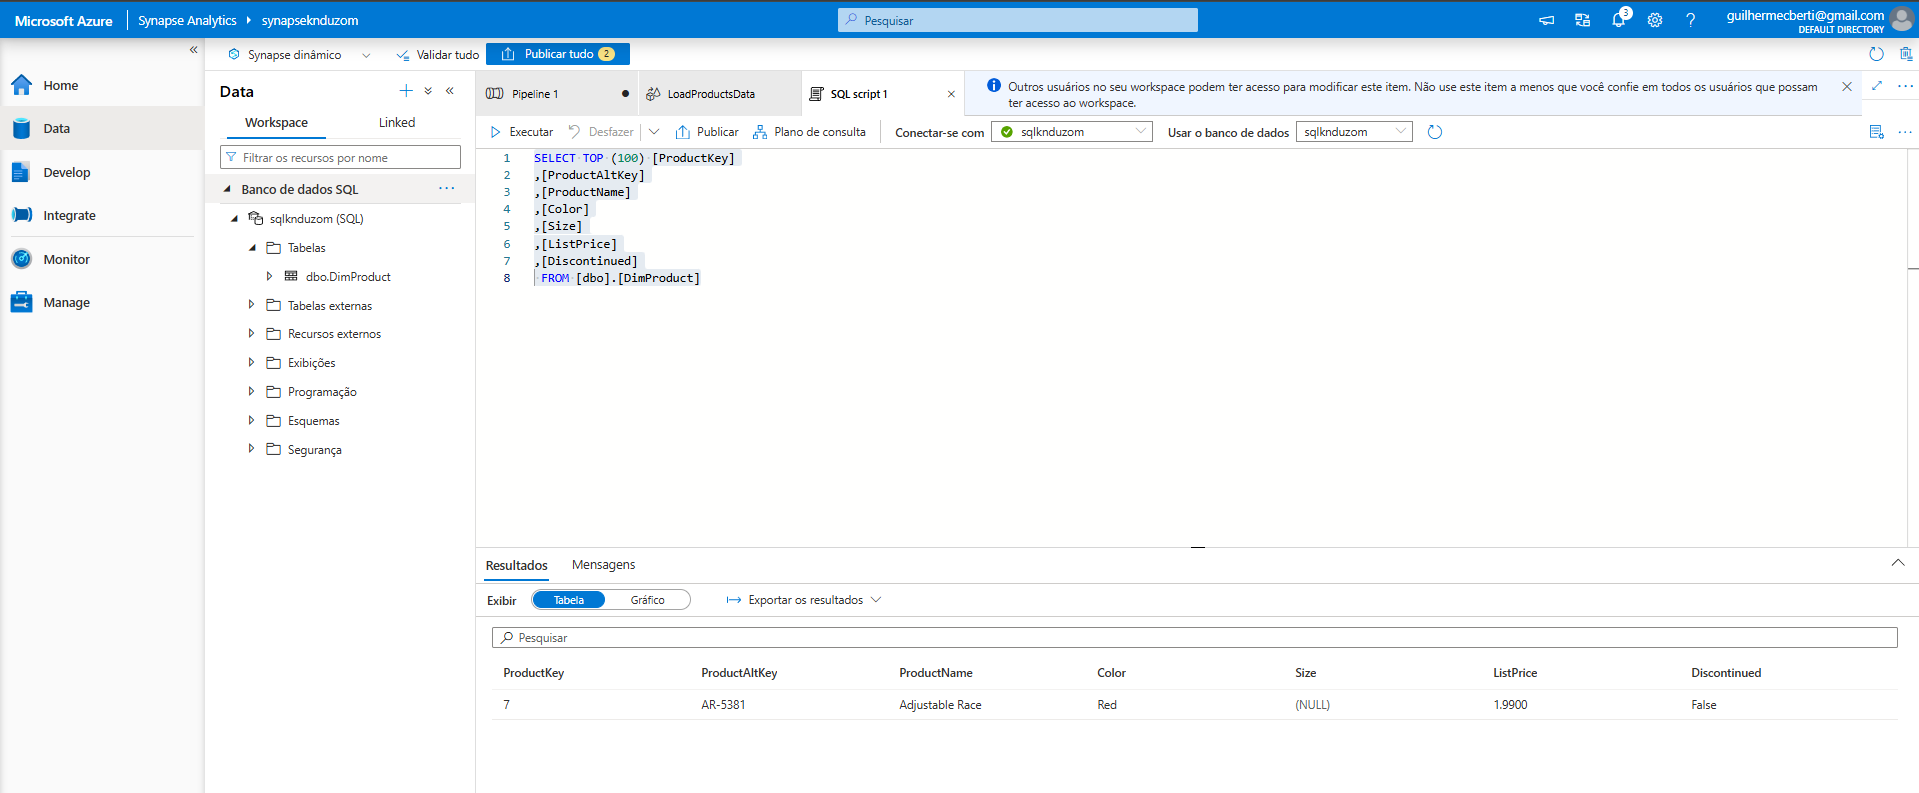